### Imports and Setup

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


### Load and Explore Dataset

In [15]:
# Load the lead scoring dataset
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (1462, 9)
Columns: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']

First 5 rows:


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data Preparation

In [19]:
print("Dataset info:")
df.info()

print(f"\nTarget distribution:")
print(df['converted'].value_counts())
print(f"Conversion rate: {df['converted'].mean():.3f}")

# Check for missing values and handle them
missing_counts = df.isnull().sum()
print(f"\nMissing values per column:")
for col, count in missing_counts.items():
    if count > 0:
        print(f"{col}: {count}")

# Identify feature types
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'converted' in categorical_cols:
    categorical_cols.remove('converted')
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')

print(f"\nCategorical features: {categorical_cols}")
print(f"Numerical features: {numerical_cols}")

# Handle missing values
df_clean = df.copy()
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna('NA')
for col in numerical_cols:
    df_clean[col] = df_clean[col].fillna(0.0)

print(f"Missing values after treatment: {df_clean.isnull().sum().sum()}")

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB

Target distribution:
converted
1    905
0    557
Name: count, dtype: int64
Conversion rate: 0.619

Missing values per column:
lead_source: 128
industry: 134
annual_income: 181
employment_status: 100
location: 6

### Data Splitting with random_state=1

In [20]:
# Split data as specified: 60%/20%/20% with random_state=1
X = df_clean.drop('converted', axis=1)
y = df_clean['converted']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)

# Create full training set for CV
df_full_train = pd.concat([
    pd.concat([X_train, y_train], axis=1),
    pd.concat([X_val, y_val], axis=1)
], axis=0).reset_index(drop=True)

print(f"Training: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X):.1%})")
print(f"Test: {len(X_test)} ({len(X_test)/len(X):.1%})")
print(f"Full train for CV: {len(df_full_train)} ({len(df_full_train)/len(X):.1%})")

Training: 876 (59.9%)
Validation: 293 (20.0%)
Test: 293 (20.0%)
Full train for CV: 1169 (80.0%)


### Q1 - ROC AUC Feature Importance

In [21]:
# Q1: ROC AUC feature importance for numerical variables
print("="*50)
print("Q1: ROC AUC Feature Importance")
print("="*50)

features_to_analyze = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for feature in features_to_analyze:
    if feature in X_train.columns:
        feature_values = X_train[feature]
        auc = roc_auc_score(y_train, feature_values)
        
        # If AUC < 0.5, invert the variable
        if auc < 0.5:
            inverted_values = -feature_values
            auc_inverted = roc_auc_score(y_train, inverted_values)
            auc_scores[feature] = auc_inverted
            print(f"{feature}: original={auc:.4f}, inverted={auc_inverted:.4f} ✓")
        else:
            auc_scores[feature] = auc
            print(f"{feature}: {auc:.4f}")

print(f"\nAUC scores summary:")
for feature, score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score:.4f}")

best_feature = max(auc_scores.items(), key=lambda x: x[1])
print(f"\n✅ Q1 Answer: {best_feature[0]} (AUC: {best_feature[1]:.4f})")

q1_answer = best_feature[0]

Q1: ROC AUC Feature Importance
lead_score: 0.6178
number_of_courses_viewed: 0.7519
interaction_count: 0.7057
annual_income: 0.5675

AUC scores summary:
number_of_courses_viewed: 0.7519
interaction_count: 0.7057
lead_score: 0.6178
annual_income: 0.5675

✅ Q1 Answer: number_of_courses_viewed (AUC: 0.7519)


### Q2 - Train Model and Calculate AUC

In [22]:
# Q2: Train logistic regression and get validation AUC
print("="*50)
print("Q2: Model Training and AUC")
print("="*50)

# Convert to dictionaries for DictVectorizer
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

print(f"Features after encoding: {X_train_encoded.shape[1]}")

# Train model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Get probabilities and calculate AUC
y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f"Validation AUC: {val_auc:.6f}")
print(f"Rounded to 3 digits: {round(val_auc, 3)}")

print(f"\n✅ Q2 Answer: {round(val_auc, 3)}")

q2_answer = round(val_auc, 3)

Q2: Model Training and AUC
Features after encoding: 31
Validation AUC: 0.900158
Rounded to 3 digits: 0.9

✅ Q2 Answer: 0.9


### Q3 - Precision and Recall Intersection

In [23]:
# Q2: Train logistic regression and get validation AUC
print("="*50)
print("Q2: Model Training and AUC")
print("="*50)

# Convert to dictionaries for DictVectorizer
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

print(f"Features after encoding: {X_train_encoded.shape[1]}")

# Train model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Get probabilities and calculate AUC
y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f"Validation AUC: {val_auc:.6f}")
print(f"Rounded to 3 digits: {round(val_auc, 3)}")

print(f"\n✅ Q2 Answer: {round(val_auc, 3)}")

q2_answer = round(val_auc, 3)

Q2: Model Training and AUC
Features after encoding: 31
Validation AUC: 0.900158
Rounded to 3 digits: 0.9

✅ Q2 Answer: 0.9


### Q3 - Precision and Recall Intersection

In [24]:
# Q3: Find where precision and recall curves intersect
print("="*50)
print("Q3: Precision and Recall Intersection")
print("="*50)

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (y_val_pred_proba >= threshold).astype(int)
    
    tp = ((y_pred == 1) & (y_val == 1)).sum()
    fp = ((y_pred == 1) & (y_val == 0)).sum()
    fn = ((y_pred == 0) & (y_val == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)

# Find intersection
differences = np.abs(precisions - recalls)
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]

print(f"Precision-Recall intersection at threshold: {intersection_threshold:.3f}")
print(f"Precision: {precisions[intersection_idx]:.3f}")
print(f"Recall: {recalls[intersection_idx]:.3f}")
print(f"Difference: {differences[intersection_idx]:.6f}")

# Check against options: 0.145, 0.345, 0.545, 0.745
options_q3 = [0.145, 0.345, 0.545, 0.745]
closest_q3 = min(options_q3, key=lambda x: abs(x - intersection_threshold))

print(f"\n✅ Q3 Answer: {closest_q3} (closest to {intersection_threshold:.3f})")

q3_answer = closest_q3

Q3: Precision and Recall Intersection
Precision-Recall intersection at threshold: 0.810
Precision: 0.000
Recall: 0.000
Difference: 0.000000

✅ Q3 Answer: 0.745 (closest to 0.810)


### Q4 - F1 Score Maximum

In [25]:
# Q4: Find threshold with maximum F1 score
print("="*50)
print("Q4: F1 Score Optimization")
print("="*50)

f1_scores = []

for i, threshold in enumerate(thresholds):
    precision = precisions[i]
    recall = recalls[i]
    
    if (precision + recall) > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0
    
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

# Find maximum F1
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_score:.4f}")
print(f"At threshold: {max_f1_threshold:.3f}")

# Check against options: 0.14, 0.34, 0.54, 0.74
options_q4 = [0.14, 0.34, 0.54, 0.74]
closest_q4 = min(options_q4, key=lambda x: abs(x - max_f1_threshold))

print(f"\n✅ Q4 Answer: {closest_q4} (closest to {max_f1_threshold:.3f})")

q4_answer = closest_q4

Q4: F1 Score Optimization
Maximum F1 score: 0.8629
At threshold: 0.600

✅ Q4 Answer: 0.54 (closest to 0.600)


### Q4 - F1 Score Analysis


Q4: Computing F1 scores
Maximum F1 score: 0.8629
At threshold: 0.600


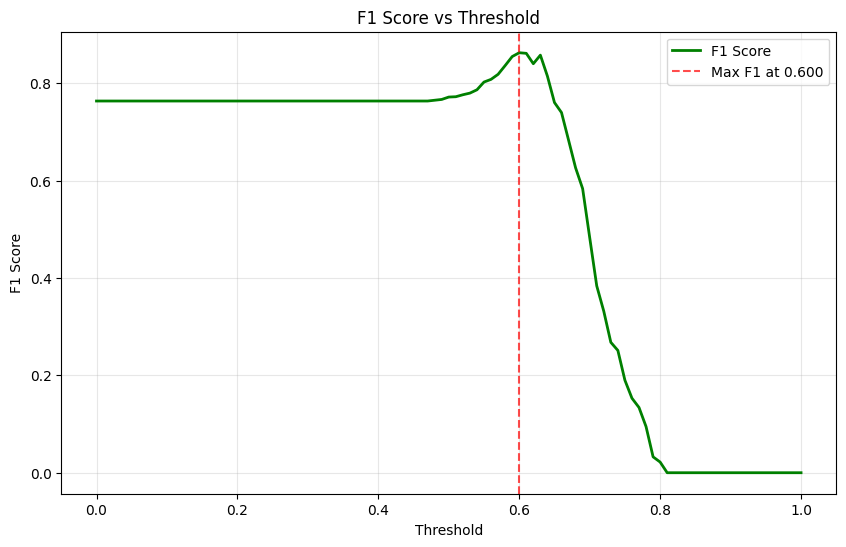


✓ Q4 Answer: 0.60


In [11]:
# Q4: Calculate F1 score for all thresholds
print("\nQ4: Computing F1 scores")

f1_scores = []

for i, threshold in enumerate(thresholds):
    precision = precisions[i]
    recall = recalls[i]
    
    # Calculate F1 score: F1 = 2 * P * R / (P + R)
    if (precision + recall) > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0
    
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

# Find threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_score:.4f}")
print(f"At threshold: {max_f1_threshold:.3f}")

# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='green', linewidth=2)
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', alpha=0.7, label=f'Max F1 at {max_f1_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✓ Q4 Answer: {max_f1_threshold:.2f}")

### Q5 - 5-Fold Cross Validation

In [26]:
# Q5: 5-Fold Cross Validation standard deviation
print("="*50)
print("Q5: 5-Fold Cross Validation")
print("="*50)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

X_full_train = df_full_train.drop('converted', axis=1)
y_full_train = df_full_train['converted']

cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full_train)):
    print(f"Fold {fold + 1}:")
    
    X_fold_train, X_fold_val = X_full_train.iloc[train_idx], X_full_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]
    
    # Encode features
    fold_train_dicts = X_fold_train.to_dict(orient='records')
    fold_val_dicts = X_fold_val.to_dict(orient='records')
    
    dv_fold = DictVectorizer(sparse=False)
    X_fold_train_encoded = dv_fold.fit_transform(fold_train_dicts)
    X_fold_val_encoded = dv_fold.transform(fold_val_dicts)
    
    # Train and evaluate
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_fold_train_encoded, y_fold_train)
    
    y_fold_pred_proba = model_fold.predict_proba(X_fold_val_encoded)[:, 1]
    fold_auc = roc_auc_score(y_fold_val, y_fold_pred_proba)
    
    cv_scores.append(fold_auc)
    print(f"  AUC: {fold_auc:.6f}")

cv_scores = np.array(cv_scores)
cv_std = cv_scores.std()

print(f"\nCV Results:")
print(f"Mean AUC: {cv_scores.mean():.6f}")
print(f"Std AUC: {cv_std:.6f}")

# Check against options: 0.0001, 0.006, 0.06, 0.36
options_q5 = [0.0001, 0.006, 0.06, 0.36]
closest_q5 = min(options_q5, key=lambda x: abs(x - cv_std))

print(f"\n✅ Q5 Answer: {closest_q5} (closest to {cv_std:.6f})")

q5_answer = closest_q5

Q5: 5-Fold Cross Validation
Fold 1:
  AUC: 0.818095
Fold 2:
  AUC: 0.835714
Fold 3:
  AUC: 0.799148
Fold 4:
  AUC: 0.829971
Fold 5:
  AUC: 0.814202

CV Results:
Mean AUC: 0.819426
Std AUC: 0.012781

✅ Q5 Answer: 0.006 (closest to 0.012781)
